- Labels in this dataset:
    - 0: motobike


- More info:
    - Number of classes: 1
    - Label Annotation: YOLO format (.txt)
      - `[class_id, center_x, center_y, width, height]`
      
___      

Yolo Dataset folder structure: the paths to these folders will be written to a YAML file that will be used by Yolo.

```
Custom dataset directory (root)
    - train
        - images (folder including all training images)
        - labels (folder including all training labels)
    - validation
        - images (folder including all validation images)
        - labels (folder including all validation labels)
    - test
        - images (folder including all test images)
        - labels (folder including all test labels)

```

In [1]:
! nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-61b313bf-7a3c-76c5-4dd5-66bfd87cc6ef)
GPU 1: Tesla T4 (UUID: GPU-f4c64e39-fcf0-b02b-c3c4-6a01b35fb918)


# Installs/Imports

In [4]:
! pip install --upgrade ultralytics -qq


In [5]:
import ultralytics
print(ultralytics.__version__)

8.2.79


In [6]:
import warnings
warnings.filterwarnings("ignore")

import os
import re
import glob
import random
import yaml

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
import torch

import IPython.display as display
from PIL import Image
import cv2

from ultralytics import YOLO

In [7]:
! wandb disabled

W&B disabled.


# CFG

- CFG class enables easy and organized experimentation
- Set `DEBUG = True` to make quick experiments

In [8]:
class CFG:
    SEED = 1
    # classes
    NUM_CLASSES = 1
    CLASSES = ['motobike']

    # training
    EPOCHS = 50 
    BATCH_SIZE = 32
    
    BASE_MODEL = 'yolov8n' # yolov8n, yolov8s, yolov8m, yolov8l, yolov8x, yolov9c, yolov9e
    BASE_MODEL_WEIGHTS = f'{BASE_MODEL}.pt'
    EXP_NAME = f'ppe_css_{EPOCHS}_epochs'
    
    OPTIMIZER = 'auto' # SGD, Adam, Adamax, AdamW, NAdam, RAdam, RMSProp, auto
    LR = 0.001
    LR_FACTOR = 0.01
    WEIGHT_DECAY = 5e-4
    DROPOUT = 0.0
    PATIENCE = 20
    PROFILE = False
    LABEL_SMOOTHING = 0.0    

    # paths
    CUSTOM_DATASET_DIR = '/kaggle/input/motobike-dectection1/motobike_Detection'
    OUTPUT_DIR = '/kaggle/working/'

# Create YAML file

- Create ```data.yaml``` file properly formatted to be used by Yolo

In [9]:
dict_file = {
    'train': os.path.join(CFG.CUSTOM_DATASET_DIR, 'train'),
    'val': os.path.join(CFG.CUSTOM_DATASET_DIR, 'valid'),
    'test': os.path.join(CFG.CUSTOM_DATASET_DIR, 'test'),
    'nc': CFG.NUM_CLASSES,
    'names': CFG.CLASSES
    }

with open(os.path.join(CFG.OUTPUT_DIR, 'data.yaml'), 'w+') as file:
    yaml.dump(dict_file, file)

In [10]:
### read yaml file created
def read_yaml_file(file_path = CFG.CUSTOM_DATASET_DIR):
    with open(file_path, 'r') as file:
        try:
            data = yaml.safe_load(file)
            return data
        except yaml.YAMLError as e:
            print("Error reading YAML:", e)
            return None

### print it with newlines
def print_yaml_data(data):
    formatted_yaml = yaml.dump(data, default_style=False)
    print(formatted_yaml)

file_path = os.path.join(CFG.OUTPUT_DIR, 'data.yaml')
yaml_data = read_yaml_file(file_path)

if yaml_data:
    print_yaml_data(yaml_data)

names:
- motobike
nc: 1
test: /kaggle/input/motobike-dectection1/motobike_Detection/test
train: /kaggle/input/motobike-dectection1/motobike_Detection/train
val: /kaggle/input/motobike-dectection1/motobike_Detection/valid



# Dataset

- Check some images
- Image utils

## Visualize one image

In [ ]:
def display_image(image, print_info = True, hide_axis = False):
    if isinstance(image, str):  # Check if it's a file path
        img = Image.open(image)
        plt.imshow(img)
    elif isinstance(image, np.ndarray):  # Check if it's a NumPy array
        image = image[..., ::-1]  # BGR to RGB
        img = Image.fromarray(image)
        plt.imshow(img)
    else:
        raise ValueError("Unsupported image format")

    if print_info:
        print('Type: ', type(img), '\n')
        print('Shape: ', np.array(img).shape, '\n')

    if hide_axis:
        plt.axis('off')

    plt.show()
    
example_image_path = '/kaggle/input/motobike-dectection1/motobike_Detection/train/images/3J4A7817_frame_0003_png.rf.3403487b97b4a315795f7b3c5762ce25.jpg'
display_image(example_image_path, print_info = True, hide_axis = False)

Type:  <class 'PIL.JpegImagePlugin.JpegImageFile'> 

Shape:  (1080, 1920, 3) 



## Visualize many images

In [ ]:
def plot_random_images_from_folder(folder_path, num_images=20, seed=CFG.SEED):

    # Get a list of image files in the folder
    image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.png', '.jpeg', '.gif'))]

    # Ensure that we have at least num_images files to choose from
    if len(image_files) < num_images:
        raise ValueError("Not enough images in the folder")

    # Randomly select num_images image files
    selected_files = random.sample(image_files, num_images)

    # Create a subplot grid
    num_cols = 5
    num_rows = (num_images + num_cols - 1) // num_cols
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))

    for i, file_name in enumerate(selected_files):
        # Open and display the image using PIL
        img = Image.open(os.path.join(folder_path, file_name))
        
        if num_rows == 1:
            ax = axes[i % num_cols]
        else:
            ax = axes[i // num_cols, i % num_cols]
        
        ax.imshow(img)
        ax.axis('off')
        # ax.set_title(file_name)

    # Remove empty subplots
    for i in range(num_images, num_rows * num_cols):
        if num_rows == 1:
            fig.delaxes(axes[i % num_cols])
        else:
            fig.delaxes(axes[i // num_cols, i % num_cols])

    plt.tight_layout()
    plt.show()
    
# folder_path = CFG.CUSTOM_DATASET_DIR + 'train/images/'
folder_path = '/kaggle/input/motobike-dectection1/motobike_Detection/train/images'
plot_random_images_from_folder(folder_path, num_images=20, seed=CFG.SEED)

## Image properties

In [ ]:
def get_image_properties(image_path):
    # Read the image file
    img = cv2.imread(image_path)

    # Check if the image file is read successfully
    if img is None:
        raise ValueError("Could not read image file")

    # Get image properties
    properties = {
        "width": img.shape[1],
        "height": img.shape[0],
        "channels": img.shape[2] if len(img.shape) == 3 else 1,
        "dtype": img.dtype,
    }

    return properties

img_properties = get_image_properties(example_image_path)
img_properties

## Dataset statistics

In [13]:
%%time
class_idx = {str(i): CFG.CLASSES[i] for i in range(CFG.NUM_CLASSES)}

class_stat = {}
data_len = {}
class_info = []

for mode in ['train', 'valid', 'test']:
    class_count = {CFG.CLASSES[i]: 0 for i in range(CFG.NUM_CLASSES)}

    path = os.path.join(CFG.CUSTOM_DATASET_DIR, mode, 'labels')

    for file in os.listdir(path):
        with open(os.path.join(path, file)) as f:
            lines = f.readlines()

            for cls in set([line[0] for line in lines]):
                class_count[class_idx[cls]] += 1

    data_len[mode] = len(os.listdir(path))
    class_stat[mode] = class_count

    class_info.append({'Mode': mode, **class_count, 'Data_Volume': data_len[mode]})

dataset_stats_df = pd.DataFrame(class_info)
dataset_stats_df


CPU times: user 123 ms, sys: 143 ms, total: 266 ms
Wall time: 4.13 s


,Mode,motobike,Data_Volume
0,train,1195,1195
1,valid,398,398
2,test,398,399


# Train

[Arguments for training](https://docs.ultralytics.com/modes/train/#arguments)

In [14]:
### Load pre-trained YOLO model
model = YOLO(CFG.BASE_MODEL_WEIGHTS)

In [12]:
!pip install -U ipywidgets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 1.6 MB/s eta 0:00:00a 0:00:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.4/214.4 kB 4.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 23.9 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.7
    Uninstalling widgetsnbextension-3.6.7:
      Successfully uninstalled widgetsnbextension-3.6.7
  Attempting uninstall: jupyterlab-widgets
    Found existing installation: jupyterlab-widgets 3.0.9
    Uninstalling jupyterlab-widgets-3.0.9:
      Successfully uninstalled jupyterlab-widgets-3.0.9
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidgets-7.7.1


In [15]:
# import torch
# torch.cuda.empty_cache()
# cuda_available = torch.cuda.is_available()
# print(cuda_available)
!rm -rf /kaggle/working/runs
# !pip install GPUtil
# import torch
# from GPUtil import showUtilization as gpu_usage
# from numba import cuda

# def free_gpu_cache():
#     print("Initial GPU Usage")
#     gpu_usage()                             

#     torch.cuda.empty_cache()

#     cuda.select_device(0)
#     cuda.close()
#     cuda.select_device(0)

#     print("GPU Usage after emptying the cache")
#     gpu_usage()

# free_gpu_cache()  

In [16]:
### train
results = model.train(
    data=os.path.join(CFG.OUTPUT_DIR, 'data.yaml'),
    epochs = CFG.EPOCHS,
    batch = CFG.BATCH_SIZE,
    optimizer = CFG.OPTIMIZER,
    lr0 = CFG.LR,
    lrf = CFG.LR_FACTOR,
#     imgsz = (img_properties['height'], img_properties['width']),
    imgsz = (640,640),
    seed = CFG.SEED,
    device = '0,1', #[0,1], # 0
    workers=4,
    name='yolov8n_MotobikeDetection'),

Ultralytics YOLOv8.2.79 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15095MiB)
                                                      CUDA:1 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/kaggle/working/data.yaml, epochs=50, time=None, patience=100, batch=32, imgsz=(640, 640), save=True, save_period=-1, cache=False, device=0,1, workers=4, project=None, name=yolov8n_MotobikeDetection, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=1, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_fr

100%|██████████| 755k/755k [00:00<00:00, 14.7MB/s]
2024-08-19 18:58:48,488	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-08-19 18:58:49,368	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

train: Scanning /kaggle/input/motobike-dectection1/motobike_Detection/train/labels... 1195 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1195/1195 [00:06<00:00, 182.23it/s]


train: WARNING ⚠️ Cache directory /kaggle/input/motobike-dectection1/motobike_Detection/train is not writeable, cache not saved.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
train: Scanning /kaggle/input/motobike-dectection1/motobike_Detection/train/labels... 1195 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1195/1195 [00:01<00:00, 716.66it/s]
val: Scanning /kaggle/input/motobike-dectection1/motobike_Detection/valid/labels... 398 images, 0 backgrounds, 0 corrupt: 100%|██████████| 398/398 [00:02<00:00, 182.90it/s]


val: WARNING ⚠️ Cache directory /kaggle/input/motobike-dectection1/motobike_Detection/valid is not writeable, cache not saved.
Plotting labels to runs/detect/yolov8n_MotobikeDetection/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/yolov8n_MotobikeDetection
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      2.63G     0.9206      1.658     0.9974         15        640: 100%|██████████| 38/38 [00:18<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:04<00:00,  2.65it/s]


                   all        398        593      0.995      0.615      0.986      0.784

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      2.28G     0.8032     0.9312     0.9291         22        640: 100%|██████████| 38/38 [00:15<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.67it/s]


                   all        398        593      0.965      0.981       0.99      0.799

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      2.29G     0.7766     0.7873     0.9179         22        640: 100%|██████████| 38/38 [00:14<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.51it/s]


                   all        398        593       0.96      0.992      0.989      0.769

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      2.27G     0.7588     0.7465     0.9158         15        640: 100%|██████████| 38/38 [00:15<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.62it/s]


                   all        398        593      0.964       0.99      0.985      0.795

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      2.28G      0.768     0.6884     0.9243         24        640: 100%|██████████| 38/38 [00:15<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.59it/s]


                   all        398        593      0.975      0.984      0.992      0.804

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50       2.3G      0.748     0.6202     0.9121         25        640: 100%|██████████| 38/38 [00:14<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.45it/s]


                   all        398        593      0.976      0.981      0.993       0.81

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      2.28G     0.7325     0.5953     0.9137         18        640: 100%|██████████| 38/38 [00:14<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:04<00:00,  3.16it/s]


                   all        398        593       0.97      0.989      0.989      0.805

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      2.27G      0.735      0.572     0.9166         19        640: 100%|██████████| 38/38 [00:15<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.58it/s]


                   all        398        593       0.97       0.99      0.988        0.8

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      2.27G      0.722     0.5457     0.9075         26        640: 100%|██████████| 38/38 [00:14<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.51it/s]


                   all        398        593      0.982       0.99      0.993      0.808

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      2.29G     0.7284     0.5212     0.9152         18        640: 100%|██████████| 38/38 [00:13<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.48it/s]


                   all        398        593      0.977      0.986      0.989      0.806

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      2.27G     0.7153      0.517     0.9129         21        640: 100%|██████████| 38/38 [00:14<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.42it/s]


                   all        398        593      0.977      0.993      0.988      0.762

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      2.29G     0.7154     0.4838     0.9044         19        640: 100%|██████████| 38/38 [00:15<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.59it/s]


                   all        398        593      0.978      0.979      0.991      0.808

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      2.27G     0.6972     0.4762     0.9026         25        640: 100%|██████████| 38/38 [00:14<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.61it/s]


                   all        398        593      0.977      0.988      0.994      0.801

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      2.29G     0.6898     0.4536     0.8965         19        640: 100%|██████████| 38/38 [00:15<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.86it/s]


                   all        398        593       0.98      0.985      0.991      0.799

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      2.27G      0.696     0.4546     0.9097         16        640: 100%|██████████| 38/38 [00:13<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:04<00:00,  2.99it/s]


                   all        398        593      0.976       0.99      0.988      0.806

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      2.27G      0.684     0.4445     0.9052         19        640: 100%|██████████| 38/38 [00:14<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.50it/s]


                   all        398        593      0.988      0.984      0.994      0.818

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      2.29G     0.6788      0.444     0.8983         18        640: 100%|██████████| 38/38 [00:14<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.46it/s]


                   all        398        593       0.98      0.993      0.993      0.818

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      2.29G      0.667     0.4279      0.895         26        640: 100%|██████████| 38/38 [00:13<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.59it/s]


                   all        398        593      0.973      0.993      0.992      0.799

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      2.27G      0.692     0.4195     0.9052         13        640: 100%|██████████| 38/38 [00:14<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.64it/s]


                   all        398        593      0.985       0.98      0.993      0.818

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      2.27G     0.6433     0.4123     0.8831         15        640: 100%|██████████| 38/38 [00:14<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:04<00:00,  3.14it/s]


                   all        398        593      0.973      0.989      0.993      0.795

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      2.27G     0.6667     0.4104     0.8923         11        640: 100%|██████████| 38/38 [00:14<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.45it/s]


                   all        398        593      0.988      0.977      0.993      0.799

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      2.27G     0.6635     0.4006      0.889         11        640: 100%|██████████| 38/38 [00:15<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.66it/s]


                   all        398        593      0.982      0.988      0.993      0.806

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      2.27G     0.6561     0.3971     0.8955         13        640: 100%|██████████| 38/38 [00:13<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.63it/s]


                   all        398        593       0.98      0.985      0.989      0.808

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      2.27G     0.6631     0.3926     0.8863         21        640: 100%|██████████| 38/38 [00:15<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.51it/s]


                   all        398        593      0.974      0.987      0.992      0.834

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      2.29G     0.6879     0.3884     0.9033         15        640: 100%|██████████| 38/38 [00:15<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.72it/s]


                   all        398        593      0.983      0.988      0.994      0.806

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      2.29G     0.6291      0.379     0.8856         16        640: 100%|██████████| 38/38 [00:14<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.52it/s]


                   all        398        593      0.983      0.979      0.994      0.829

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      2.27G     0.6351     0.3717     0.8935         12        640: 100%|██████████| 38/38 [00:14<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.46it/s]


                   all        398        593      0.983      0.983      0.994      0.828

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      2.29G     0.6387       0.37     0.8924         19        640: 100%|██████████| 38/38 [00:14<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.40it/s]


                   all        398        593      0.979      0.997      0.993       0.82

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      2.29G     0.6376     0.3662     0.8869         21        640: 100%|██████████| 38/38 [00:15<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:04<00:00,  2.85it/s]


                   all        398        593      0.983      0.983      0.993      0.833

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      2.29G     0.6263     0.3586     0.8899         19        640: 100%|██████████| 38/38 [00:15<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.74it/s]


                   all        398        593      0.973      0.984      0.993      0.836

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      2.29G     0.6325     0.3537     0.8866         18        640: 100%|██████████| 38/38 [00:14<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.36it/s]


                   all        398        593      0.981      0.981      0.993      0.818

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      2.29G      0.629     0.3605     0.8856         17        640: 100%|██████████| 38/38 [00:15<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.64it/s]


                   all        398        593      0.975      0.989      0.992      0.836

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      2.29G     0.6357     0.3581     0.8911         11        640: 100%|██████████| 38/38 [00:15<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.68it/s]


                   all        398        593      0.986      0.985      0.993      0.828

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      2.29G     0.6297     0.3563     0.8875         21        640: 100%|██████████| 38/38 [00:14<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.55it/s]


                   all        398        593      0.985       0.99      0.993      0.838

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      2.29G     0.6093     0.3394      0.883         16        640: 100%|██████████| 38/38 [00:14<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.58it/s]


                   all        398        593       0.98      0.992      0.993      0.835

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      2.27G     0.5993     0.3284     0.8875         12        640: 100%|██████████| 38/38 [00:14<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.39it/s]


                   all        398        593      0.994       0.98      0.993      0.832

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      2.27G     0.6228     0.3349     0.8895         12        640: 100%|██████████| 38/38 [00:14<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.76it/s]


                   all        398        593      0.982      0.985      0.993      0.835

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      2.27G     0.5929     0.3273     0.8759         20        640: 100%|██████████| 38/38 [00:14<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.56it/s]


                   all        398        593      0.988      0.979      0.994      0.846

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      2.29G     0.6069      0.328     0.8799         13        640: 100%|██████████| 38/38 [00:14<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.46it/s]


                   all        398        593      0.977      0.981      0.993      0.832

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      2.27G     0.5896     0.3208     0.8733         23        640: 100%|██████████| 38/38 [00:15<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.71it/s]


                   all        398        593      0.981      0.987      0.993      0.839
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      2.27G     0.5617      0.293     0.8481         11        640: 100%|██████████| 38/38 [00:16<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:04<00:00,  3.19it/s]


                   all        398        593      0.988      0.986      0.992      0.829

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      2.27G     0.5642     0.2827     0.8556         11        640: 100%|██████████| 38/38 [00:13<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.53it/s]


                   all        398        593      0.993      0.981      0.992       0.83

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      2.27G     0.5475     0.2775     0.8492          8        640: 100%|██████████| 38/38 [00:14<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.55it/s]


                   all        398        593      0.987      0.978      0.992      0.834

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      2.27G      0.545     0.2804     0.8459          7        640: 100%|██████████| 38/38 [00:14<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.57it/s]


                   all        398        593      0.993      0.971      0.993       0.83

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      2.27G     0.5229     0.2654     0.8358         11        640: 100%|██████████| 38/38 [00:14<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.66it/s]


                   all        398        593      0.985       0.98      0.992      0.843

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      2.27G     0.5516     0.2698     0.8512          8        640: 100%|██████████| 38/38 [00:14<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.42it/s]


                   all        398        593      0.988      0.985      0.993      0.842

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      2.27G      0.527     0.2637     0.8363         11        640: 100%|██████████| 38/38 [00:14<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.71it/s]


                   all        398        593      0.985      0.989      0.993      0.838

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      2.27G     0.5208     0.2569     0.8369          7        640: 100%|██████████| 38/38 [00:14<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.68it/s]


                   all        398        593      0.985      0.985      0.993      0.845

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      2.27G     0.5168     0.2505     0.8443          9        640: 100%|██████████| 38/38 [00:13<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.60it/s]


                   all        398        593      0.984      0.985      0.994      0.844

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      2.27G     0.5248     0.2536     0.8361          8        640: 100%|██████████| 38/38 [00:15<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.68it/s]


                   all        398        593      0.985      0.983      0.993      0.848

50 epochs completed in 0.275 hours.
Optimizer stripped from runs/detect/yolov8n_MotobikeDetection/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/yolov8n_MotobikeDetection/weights/best.pt, 6.2MB

Validating runs/detect/yolov8n_MotobikeDetection/weights/best.pt...
Ultralytics YOLOv8.2.79 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15095MiB)
                                                      CUDA:1 (Tesla T4, 15095MiB)
Model summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:04<00:00,  2.91it/s]


                   all        398        593      0.985      0.983      0.993      0.848
Speed: 0.1ms preprocess, 1.7ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs/detect/yolov8n_MotobikeDetection


# Export

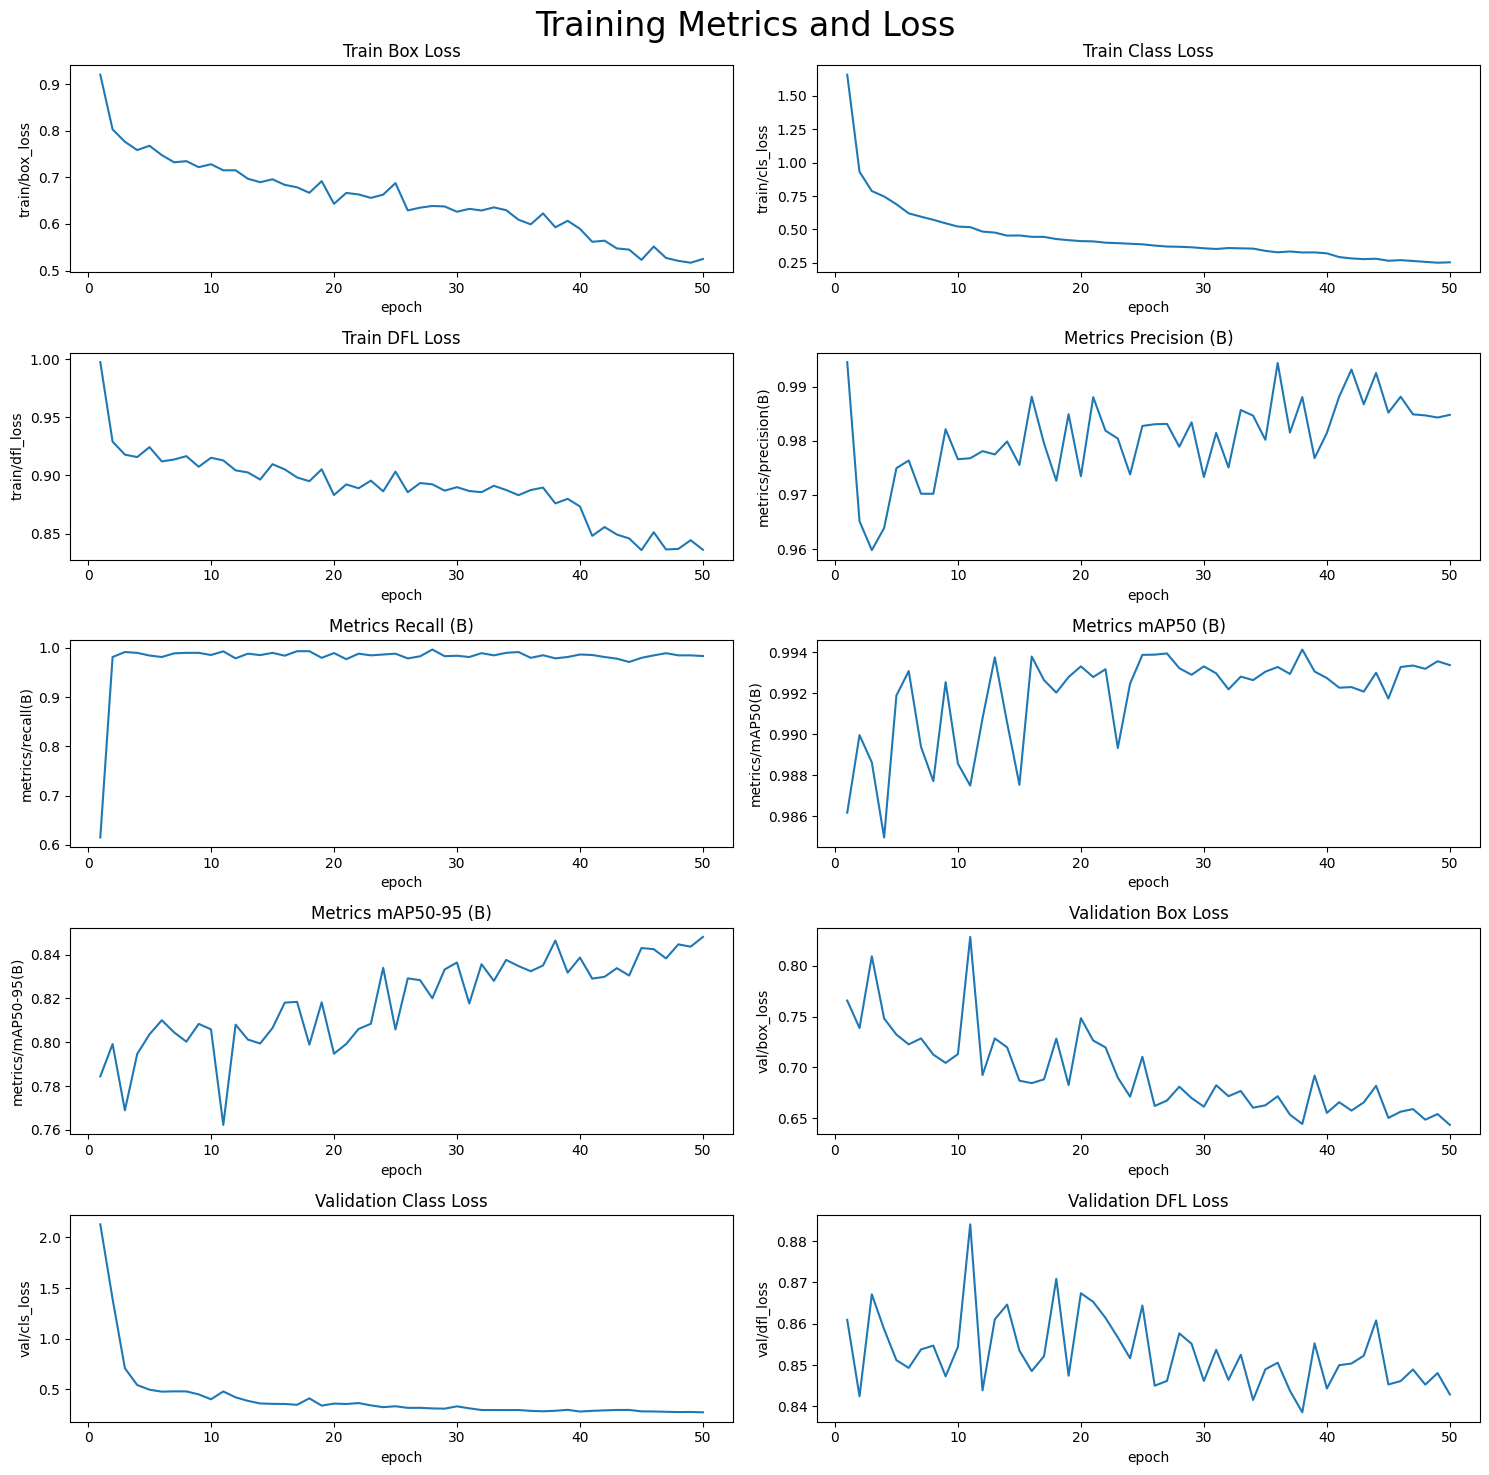

In [17]:
%matplotlib inline
# read in the results.csv file as a pandas dataframe
df = pd.read_csv('/kaggle/working/runs/detect/yolov8n_MotobikeDetection/results.csv')
df.columns = df.columns.str.strip()

# create subplots using seaborn
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(15, 15))

# plot the columns using seaborn
sns.lineplot(x='epoch', y='train/box_loss', data=df, ax=axs[0,0])
sns.lineplot(x='epoch', y='train/cls_loss', data=df, ax=axs[0,1])
sns.lineplot(x='epoch', y='train/dfl_loss', data=df, ax=axs[1,0])
sns.lineplot(x='epoch', y='metrics/precision(B)', data=df, ax=axs[1,1])
sns.lineplot(x='epoch', y='metrics/recall(B)', data=df, ax=axs[2,0])
sns.lineplot(x='epoch', y='metrics/mAP50(B)', data=df, ax=axs[2,1])
sns.lineplot(x='epoch', y='metrics/mAP50-95(B)', data=df, ax=axs[3,0])
sns.lineplot(x='epoch', y='val/box_loss', data=df, ax=axs[3,1])
sns.lineplot(x='epoch', y='val/cls_loss', data=df, ax=axs[4,0])
sns.lineplot(x='epoch', y='val/dfl_loss', data=df, ax=axs[4,1])

# set titles and axis labels for each subplot
axs[0,0].set(title='Train Box Loss')
axs[0,1].set(title='Train Class Loss')
axs[1,0].set(title='Train DFL Loss')
axs[1,1].set(title='Metrics Precision (B)')
axs[2,0].set(title='Metrics Recall (B)')
axs[2,1].set(title='Metrics mAP50 (B)')
axs[3,0].set(title='Metrics mAP50-95 (B)')
axs[3,1].set(title='Validation Box Loss')
axs[4,0].set(title='Validation Class Loss')
axs[4,1].set(title='Validation DFL Loss')

# add suptitle and subheader
plt.suptitle('Training Metrics and Loss', fontsize=24)

# adjust top margin to make space for suptitle
plt.subplots_adjust(top=0.8)

# adjust spacing between subplots
plt.tight_layout()

plt.show()

# Evaluation

In [18]:
# Loading the best performing model
model = YOLO('/kaggle/working/runs/detect/yolov8n_MotobikeDetection/weights/best.pt')

# Evaluating the model on test dataset
metrics = model.val(conf=0.25, split='test')

Ultralytics YOLOv8.2.79 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /kaggle/input/motobike-dectection1/motobike_Detection/test/labels... 399 images, 1 backgrounds, 0 corrupt: 100%|██████████| 399/399 [00:02<00:00, 178.73it/s]

val: WARNING ⚠️ Cache directory /kaggle/input/motobike-dectection1/motobike_Detection/test is not writeable, cache not saved.



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:04<00:00,  5.01it/s]


                   all        399        600      0.993      0.988      0.993      0.854
Speed: 0.2ms preprocess, 3.9ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to runs/detect/val


In [19]:
print(f"Mean Average Precision @.5:.95 : {metrics.box.map}")    
print(f"Mean Average Precision @ .50   : {metrics.box.map50}") 
print(f"Mean Average Precision @ .70   : {metrics.box.map75}")

Mean Average Precision @.5:.95 : 0.8543668609619267
Mean Average Precision @ .50   : 0.9928987003896379
Mean Average Precision @ .70   : 0.9906493583249014


# Test model



image 1/399 /kaggle/input/motobike-dectection1/motobike_Detection/test/images/3J4A7817_frame_0005_png.rf.88b5e777d974d4e696a4e4a83cfc6492.jpg: 384x640 1 motobike, 80.9ms
image 2/399 /kaggle/input/motobike-dectection1/motobike_Detection/test/images/3J4A7817_frame_0012_png.rf.34794bc0be162fce338596a5b39e4ffb.jpg: 384x640 1 motobike, 6.8ms
image 3/399 /kaggle/input/motobike-dectection1/motobike_Detection/test/images/3J4A7817_frame_0014_png.rf.16ad36c5dc3d69d624a18191cc7cc499.jpg: 384x640 2 motobikes, 7.0ms
image 4/399 /kaggle/input/motobike-dectection1/motobike_Detection/test/images/3J4A7817_frame_0014_png.rf.648caf0d8125be251560d0c88bc9bb1d.jpg: 384x640 2 motobikes, 7.6ms
image 5/399 /kaggle/input/motobike-dectection1/motobike_Detection/test/images/3J4A7817_frame_0037_png.rf.8760a4ad236c6a0724d25712b0baabdf.jpg: 384x640 1 motobike, 7.2ms
image 6/399 /kaggle/input/motobike-dectection1/motobike_Detection/test/images/3J4A7817_frame_0038_png.rf.b47385379294a55ee7114263f76d530b.jpg: 384x640 

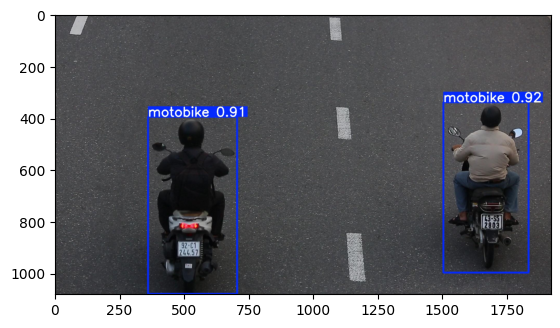

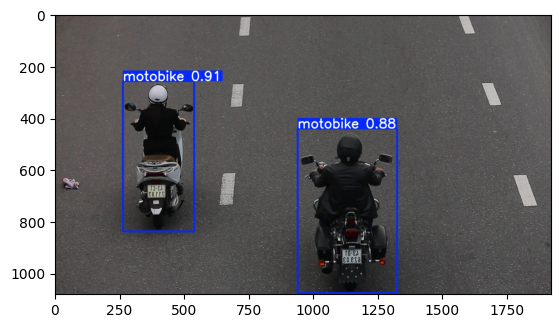

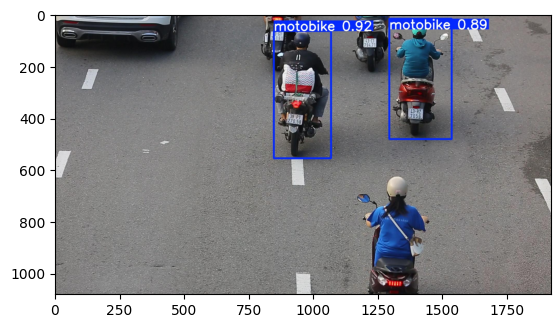

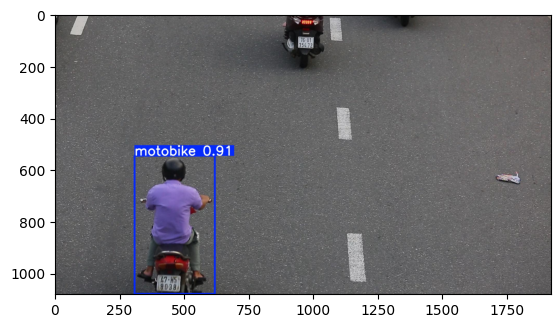

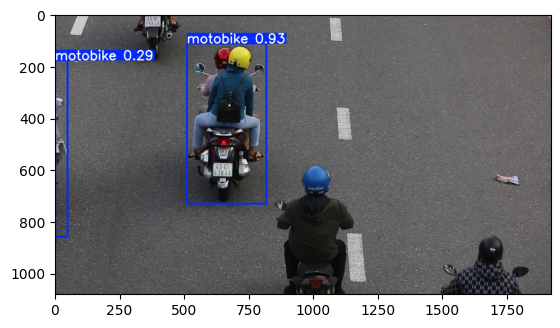

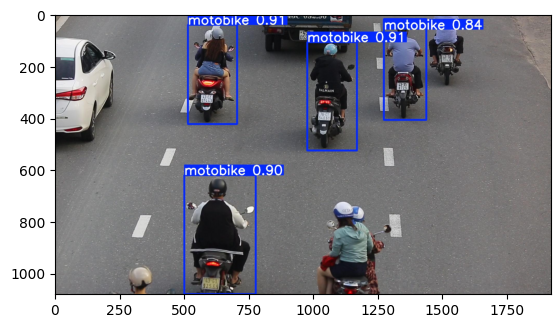

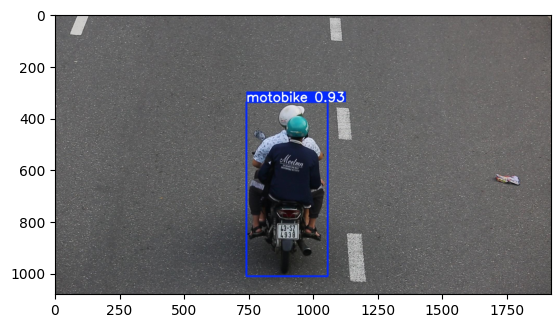

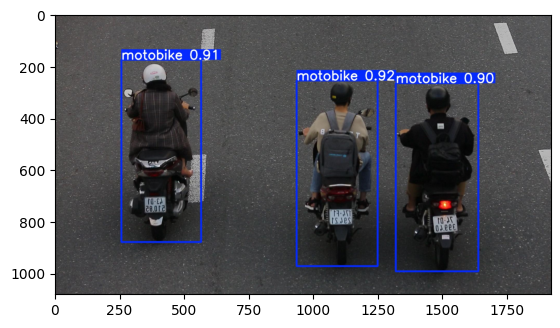

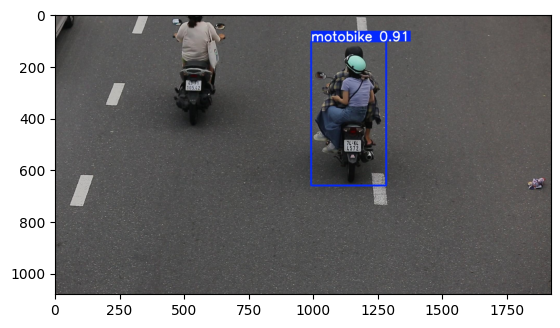

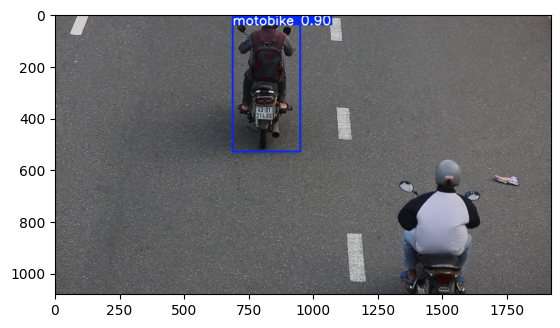

In [20]:
results = model.predict(source=os.path.join(CFG.CUSTOM_DATASET_DIR, 'test', 'images'), save=True)
%matplotlib inline

predicitions = glob.glob(os.path.join(CFG.OUTPUT_DIR, 'runs/detect/predict', '*'))

n = 10

for i in range(n):
    idx = np.random.randint(0, len(predicitions))
    image = Image.open(predicitions[idx])
    plt.imshow(image)
    plt.grid(False)
    plt.show()

In [21]:
!zip -r output.zip /kaggle/working/

  adding: kaggle/working/ (stored 0%)
  adding: kaggle/working/.virtual_documents/ (stored 0%)
  adding: kaggle/working/wandb/ (stored 0%)
  adding: kaggle/working/wandb/settings (stored 0%)
  adding: kaggle/working/runs/ (stored 0%)
  adding: kaggle/working/runs/detect/ (stored 0%)
  adding: kaggle/working/runs/detect/yolov8n_MotobikeDetection/ (stored 0%)
  adding: kaggle/working/runs/detect/yolov8n_MotobikeDetection/val_batch1_labels.jpg (deflated 7%)
  adding: kaggle/working/runs/detect/yolov8n_MotobikeDetection/PR_curve.png (deflated 28%)
  adding: kaggle/working/runs/detect/yolov8n_MotobikeDetection/P_curve.png (deflated 26%)
  adding: kaggle/working/runs/detect/yolov8n_MotobikeDetection/train_batch1522.jpg (deflated 14%)
  adding: kaggle/working/runs/detect/yolov8n_MotobikeDetection/train_batch0.jpg (deflated 6%)
  adding: kaggle/working/runs/detect/yolov8n_MotobikeDetection/weights/ (stored 0%)
  adding: kaggle/working/runs/detect/yolov8n_MotobikeDetection/weights/best.pt (defl